### Imports

In [74]:
from dicl import dicl
from dicl.icl import iclearner as icl

import importlib
importlib.reload(dicl)
importlib.reload(icl)

<module 'dicl.icl.iclearner' from '/mnt/vdb/abenechehab/dicl-adapters/src/dicl/icl/iclearner.py'>

## Load Moment model

In [ ]:
import os

os.environ["HF_HOME"] = "/mnt/vdb/hugguingface/"

from momentfm import MOMENTPipeline

forecast_horizon = 96
model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-small",
    model_kwargs={"task_name": "forecasting", "forecast_horizon": forecast_horizon},
)
model.init()

## Load data

In [ ]:
from dicl.utils.data_readers import load_rl_data

env_name = "HalfCheetah"
data_label = "expert"

# ICL parameters
context_length = 512 + forecast_horizon + 1  # 512 mandatory for MOMENT
n_features = 17

time_series = load_rl_data(env_name=env_name, data_label=data_label)
time_series = time_series[:context_length, :n_features]

print(
    f"The in-context trajectory shape is (n_timestamps:{time_series.shape[0]}, "
    f"n_features:{time_series.shape[1]})"
)

## DICL

* Instantiate disentangler (identity or pca)
* Instantiate iclearner (Moment)
* Instantiate DICL

In [75]:
disentangler = dicl.IdentityTransformer()
# disentangler = PCA(n_components=n_features)

iclearner = icl.MomentICLTrainer(
    model=model, n_features=n_features, forecast_horizon=forecast_horizon
)

DICL = dicl.DICL(
    disentangler=disentangler,
    iclearner=iclearner,
    n_features=n_features,
    n_components=n_features,
)

* Fit disentangler. This can be done using a bigger dataset than the in-context time series.

In [76]:
DICL.fit_disentangler(X=time_series)

### Autoregressive multi-step prediction and visualization

In [77]:
mean, mode, lb, ub = DICL.predict_multi_step(
    X=time_series, prediction_horizon=forecast_horizon,
)

/mnt/vdb/abenechehab/conda_envs/adapters2/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/mnt/vdb/abenechehab/conda_envs/adapters2/lib/python3.11/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


In [78]:
# print metrics
burnin = 0
single_step_metrics = DICL.compute_metrics(burnin=burnin)
print(f"after burnin steps: {burnin}")
print(
    "average_agg_squared_error: "
    f"{single_step_metrics['average_agg_squared_error']:.3f}"
)

after burnin steps: 0
average_agg_squared_error: 24.976


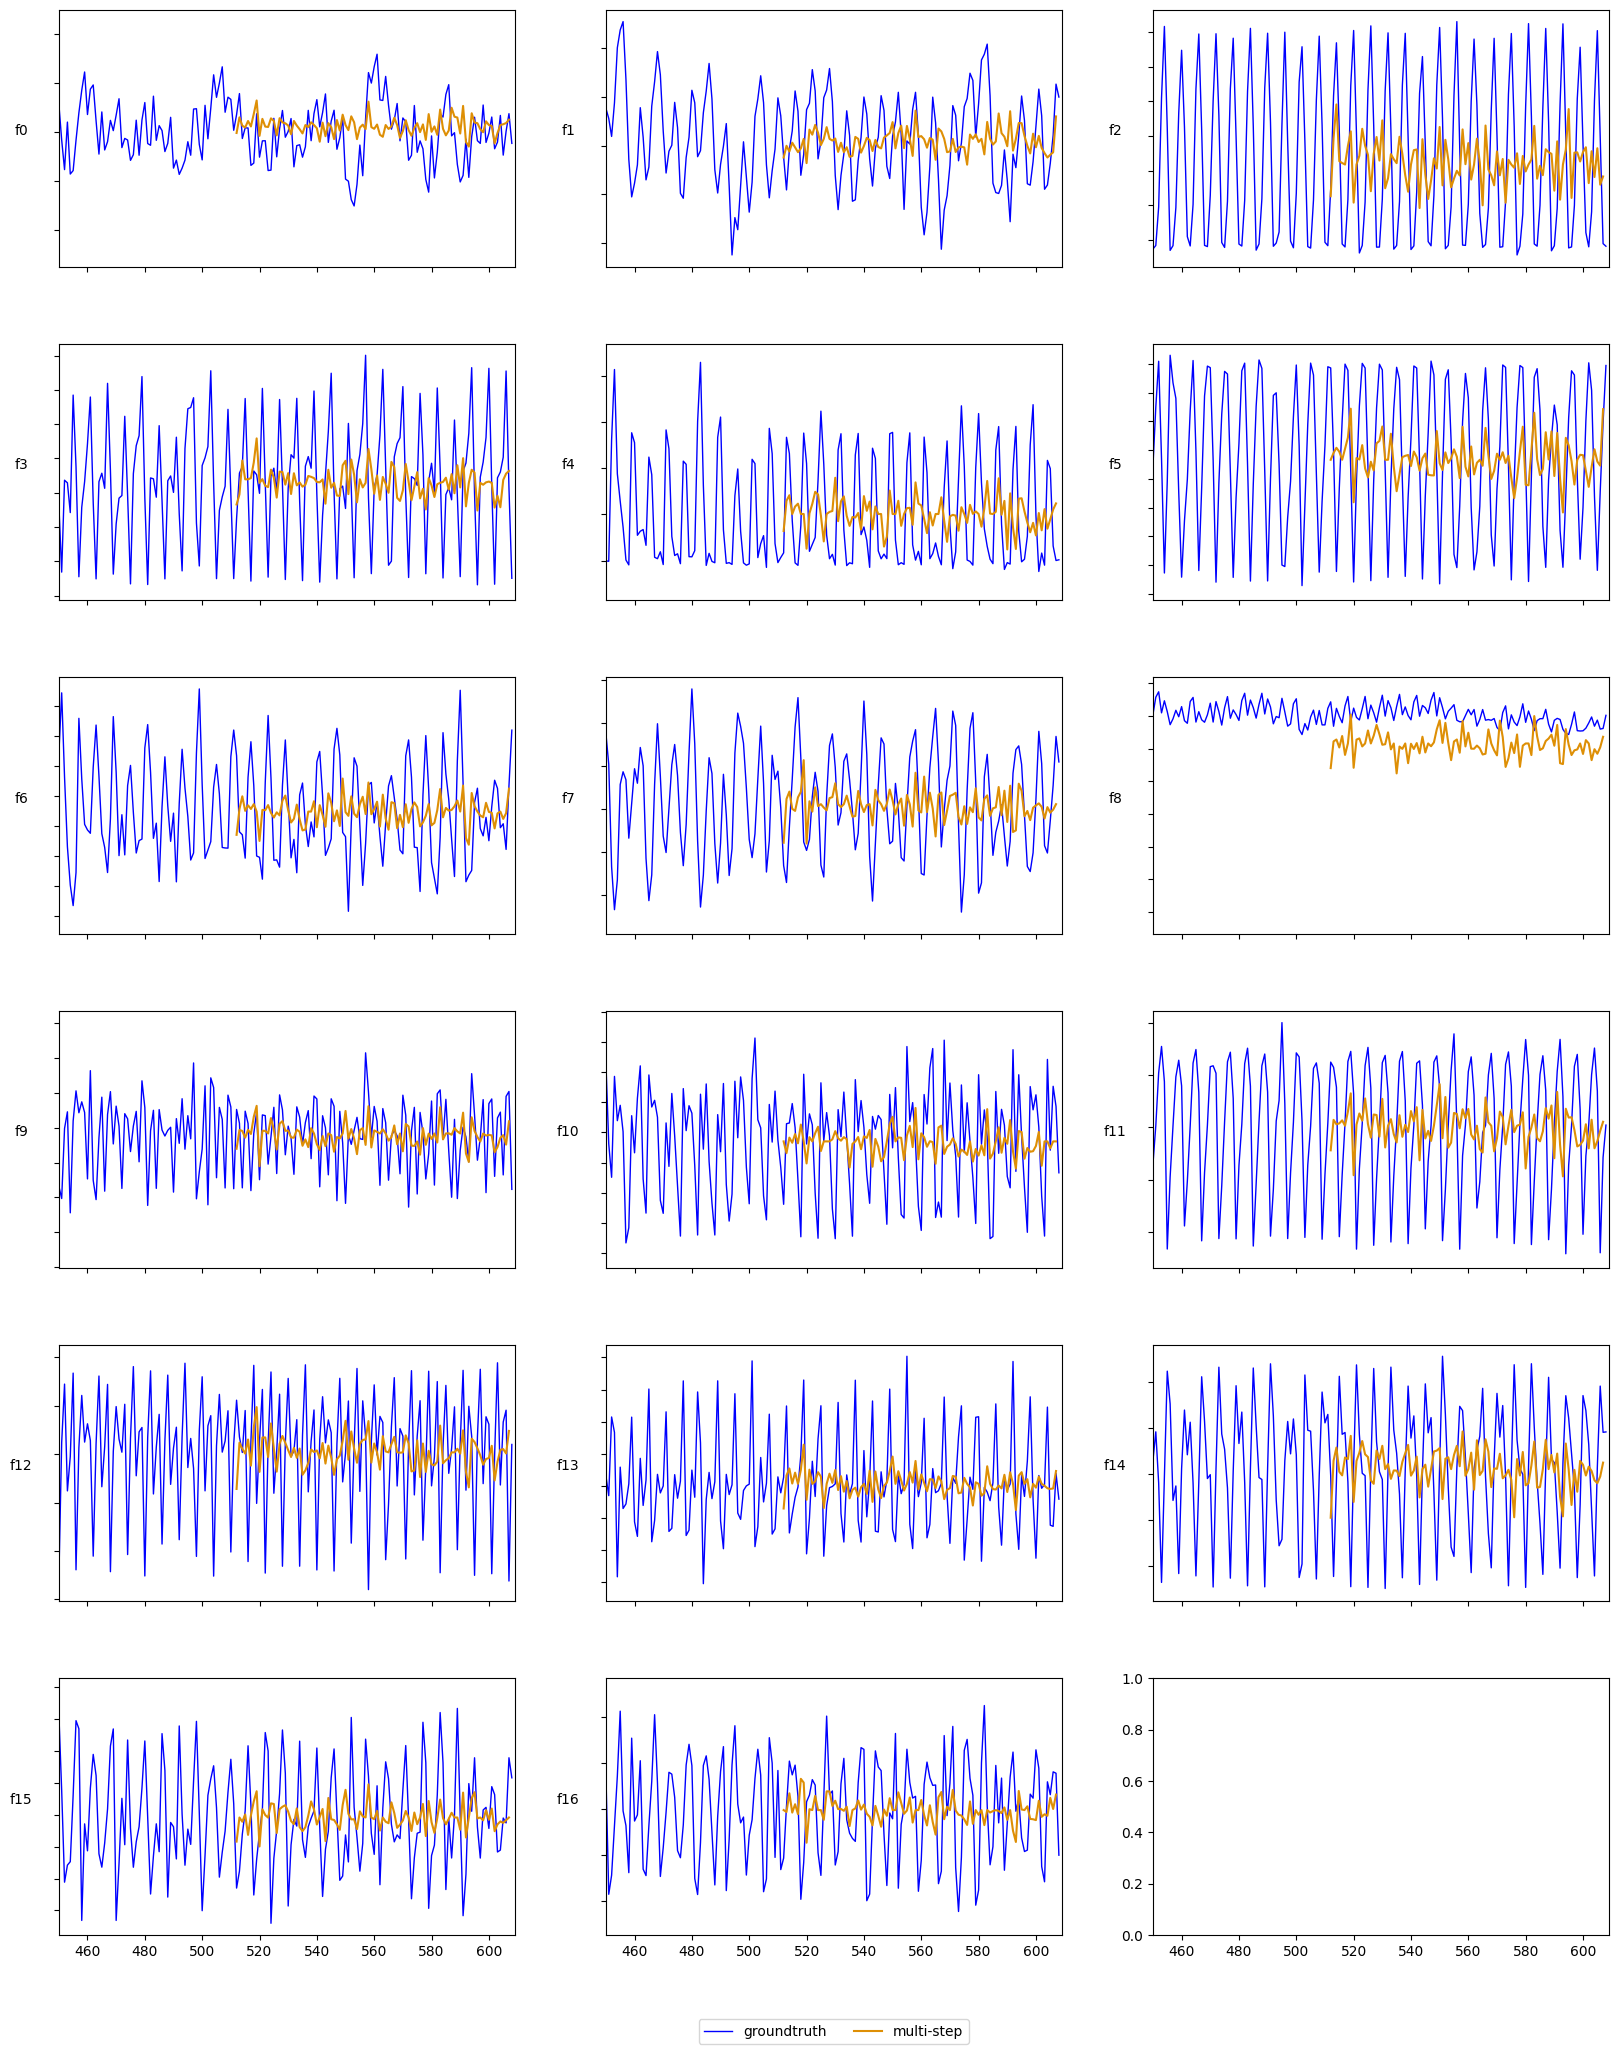

In [80]:
DICL.plot_multi_step(xlim=[450, context_length])